<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-4/3rd_Improve_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **3rd File: Improve Training**
    - Adam vs Fine tuned SGD (SGD may be better since recent papers use this)
    - Use ES with validation data. Find right num epochs.
    - Use ReduceLRonPlateau
    - Play with BatchSize
    

**Code for EarlyStopping and Checkpointing:** This is the 1st change we will make to all models
    
    
```python
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping("val_acc",patience=8,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callbacks_list = [es,checkpoint]

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=125, verbose=1, shuffle=True, validation_split=0.1, callbacks=callbacks_list,)


```

**To reload check-pointed Model**

```python
model.load_weights("model.hdf5")
```

In [0]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null

In [2]:
import pandas as pd
import numpy as np
import time
import gc
import os
import sys
import dill
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
import warnings
from data_science_utils.vision.keras import *
from keras.layers import Activation
warnings.filterwarnings("ignore")
%matplotlib inline
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import SGD, Nadam, Adam

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


In [3]:

X_train, Y_train, X_test, Y_test = get_mnist_data()
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


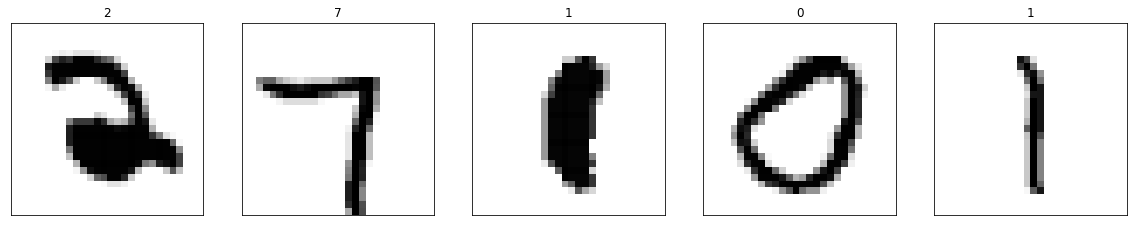

In [4]:
show_examples(X_train[10:15], Y_train[10:15],classes=get_mnist_labels())

## Architecture 3 [Selected]

We tried 32 in 1st layer and then noticed that many of these kernels were empty. So we will use dropout to add more robustness

In [5]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=5, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=30,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=100, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Params =  12846
Instructions for updating:
Use tf.cast instead.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_1', 'dropout_1', 'conv2d_2', 'conv2d_3', 'dropout_2', 'max_pooling2d_1', 'conv2d_4', 'dropout_3', 'conv2d_5', 'dropout_4', 'conv2d_6', 'dropout_5', 'conv2d_7', 'conv2d_8', 'flatten_1', 'activation_1']
Validation Loss (0.018325370049476625, 0.9941999975204467)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 

## Batch Size vs Accuracy

In [0]:
def run_model(batch_size):
  model = Sequential()
  model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
  model.add(Dropout(0.2))
  model.add(Convolution2D(10, 1, activation='relu'))
  model.add(Convolution2D(16, 3,3, activation='relu')) # 24
  model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=(2, 2))) #12

  model.add(Convolution2D(16, 3,3, activation='relu')) # 10
  model.add(Dropout(0.15))
  model.add(Convolution2D(16, 3,3, activation='relu')) # 8
  model.add(Dropout(0.15))
  model.add(Convolution2D(16, 3,3, activation='relu')) #6
  model.add(Dropout(0.1))
  model.add(Convolution2D(10, 1, activation='relu')) #6
  model.add(Convolution2D(10, 6,6))

  model.add(Flatten())
  model.add(Activation('softmax'))

  reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=0)
  es = EarlyStopping("val_acc",patience=20,restore_best_weights=True)
  checkpoint = ModelCheckpoint("model_2.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
  callbacks_list = [es,checkpoint,reduce_lr]
  optimizer = Adam(lr=0.005,)


  model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy'])

  train_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=60, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
  model.load_weights("model_2.hdf5")

  (_,train_acc),_ = evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=False, plot_results=False)
  (_,test_acc),_ = evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=False, plot_results=False)
  
  return train_acc,test_acc


In [0]:
!pip install tqdm

In [0]:
from tqdm import tnrange, tqdm_notebook

# Code below showed us that batch

batch_to_results = [(int(batch_size),run_model(int(batch_size))) for batch_size in tqdm_notebook(np.linspace(32,4096,50))]


## Trying Optimisers on Arch 3

### AdaBound

- We also tried NAdam and SGD
- SGD was hardest to tune
- Overall Adam always outperforms SGD and other optimisers with little tuning.
- It seems tuning SGD for better than Adam performance needs either lots of hardware or lots of time

In [7]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=5, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=30,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
callbacks_list = [checkpoint]
optimizer = AdaBound(lr=0.001)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=250, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  12846
Layer Names:  ['conv2d_9', 'dropout_6', 'conv2d_10', 'conv2d_11', 'dropout_7', 'max_pooling2d_2', 'conv2d_12', 'dropout_8', 'conv2d_13', 'dropout_9', 'conv2d_14', 'dropout_10', 'conv2d_15', 'conv2d_16', 'flatten_2', 'activation_2']
Validation Loss (0.020016211381554603, 0.9925999975204468)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  12846
Score =  [0.01171866882769391, 0.9967]
Balanced Accuracy = 99.67% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  12846
Score =  [0.019926515911379828, 0.9932]
Balanced Accuracy = 99.31% 


## Architecture 4 [Selected]
- 8->16 architecture
- Low number of Params

In [8]:

model = Sequential()

model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(8, 3,3, activation='relu')) # 10
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 6,6))



model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0002,verbose=1)
es = EarlyStopping("val_acc",patience=18,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=50, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  10972

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0002.
Layer Names:  ['conv2d_17', 'conv2d_18', 'dropout_11', 'max_pooling2d_3', 'conv2d_19', 'conv2d_20', 'dropout_12', 'conv2d_21', 'dropout_13', 'conv2d_22', 'dropout_14', 'conv2d_23', 'flatten_3', 'activation_3']
Validation Loss (0.02352585900425911, 0.9924999993324279)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.011910065615464312, 0.9967666666666667]
Balanced Accuracy = 99.67% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =

## Architecture 5 [Selected]

- Underfit
- Less params

In [9]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.2))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu')) #8
model.add(Convolution2D(10, 8,8))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0003,verbose=1)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=80, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 99.19%

Params =  11774

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0003.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0003.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0003.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.0003.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.0003.
Layer Names:  ['conv2d_24', 'conv2d_25', 'dropout_15', 'max_pooling2d_4', 'conv2d_26', 'conv2d_27', 'dropout_16', 'conv2d_28', 'dropout_17', 'conv2d_29', 'conv2d_30', 'flatten_4', 'activation_4']
Validation Loss (0.021470525214076042, 0.9931999975204467)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  11774
Score =  [0.013029502474276

## Architecture 14 [Selected]
Mixing MaxPool and Strides.
- We presume that MaxPool can be used in early part
- Towards the end we can use Strides=2 which prevents data loss which MaxPool causes, but reduces channel dimensions

In [10]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(16, (3,3,),strides=2, activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #4
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())


reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=80, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 98.89% -> 99.09% -> 99.25%

Params =  6974

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_31', 'conv2d_32', 'dropout_18', 'max_pooling2d_5', 'conv2d_33', 'dropout_19', 'conv2d_34', 'dropout_20', 'conv2d_35', 'dropout_21', 'conv2d_36', 'conv2d_37', 'flatten_5', 'activation_5']
Validation Loss (0.025851757913827895, 0.9911999946594239)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  6974
Score =  [0.016116578793805094, 0.99

# Misc Code

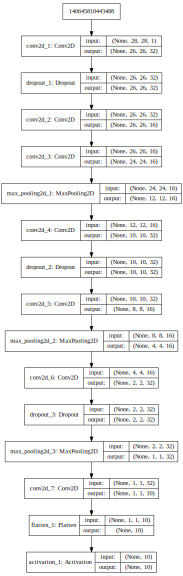

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('8x18')
SVG(m2d.create(prog='dot', format='svg'))